## Library Setup and Dependencies

In [44]:
import torch
import gzip
import matplotlib.pyplot as plt
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from typing import Tuple
import matplotlib.pyplot as plt
from collections import Counter
import torch
from torch.utils.data import DataLoader
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

## Data Loading and Processing

In [90]:
def load_data() -> Tuple[TensorDataset, TensorDataset, TensorDataset]:
    ((data_train, label_train), (data_test, label_test)) = torch.load(gzip.open('mnist.pkl.gz'))
    
    # Convert to float32
    data_train, label_train = data_train.float(), label_train.float()
    data_test, label_test = data_test.float(), label_test.float()
    
    # Split training data into train and validation (80-20)
    train_size = int(0.8 * len(data_train))
    val_size = len(data_train) - train_size
    
    full_train_dataset = TensorDataset(data_train, label_train)
    train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])
    test_dataset = TensorDataset(data_test, label_test)
    
    return train_dataset, val_dataset, test_dataset

## Plots the distribution of labels in the training, validation, and test datasets

In [50]:
def plot_data_distribution(train_dataset, val_dataset, test_dataset):
    def get_label_distribution(dataset):
        """Extracts label distribution from a dataset."""
        loader = DataLoader(dataset, batch_size=len(dataset))
        for _, labels in loader:
            return Counter(labels.numpy().flatten())

    # Get label distributions
    train_distribution = get_label_distribution(train_dataset)
    val_distribution = get_label_distribution(val_dataset)
    test_distribution = get_label_distribution(test_dataset)

    # Plot distributions
    fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
    datasets = ['Training', 'Validation', 'Test']
    distributions = [train_distribution, val_distribution, test_distribution]

    for ax, dataset, distribution in zip(axes, datasets, distributions):
        labels, counts = zip(*sorted(distribution.items()))
        ax.bar(labels, counts)
        ax.set_title(f'{dataset} Dataset')
        ax.set_xlabel('Labels')
        ax.set_ylabel('Count')

    plt.tight_layout()
    plt.show()

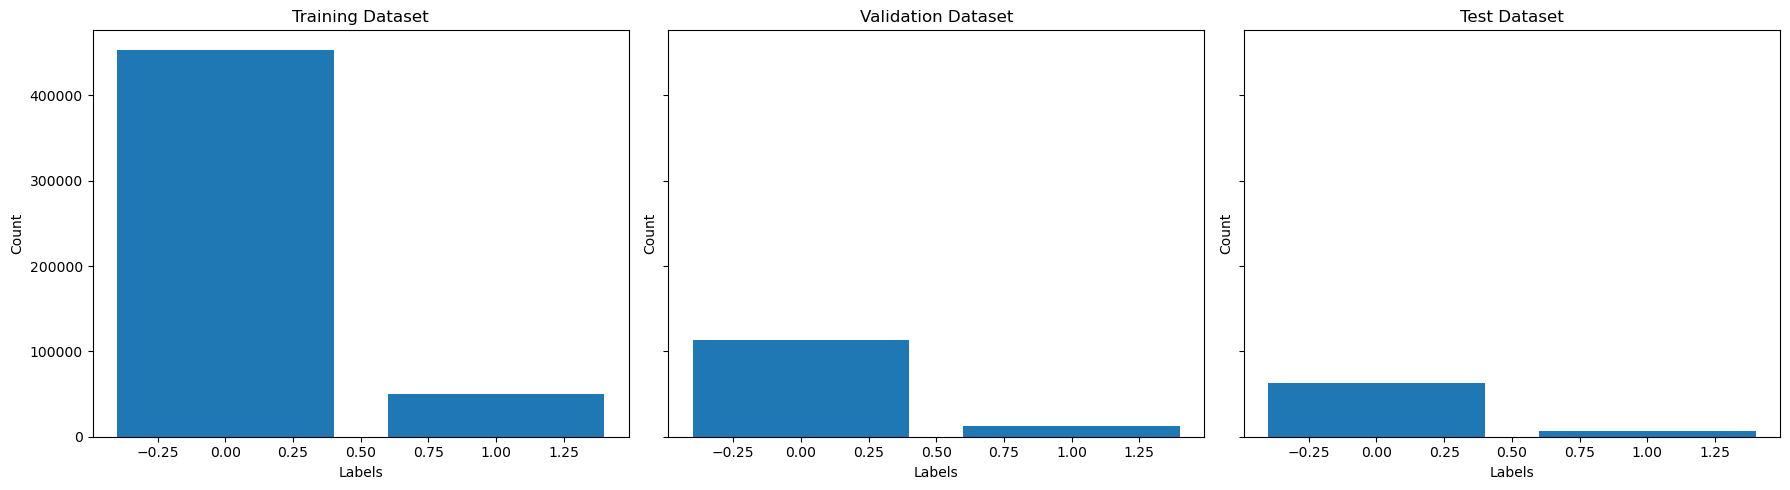

In [52]:
# Example usage
train_dataset, val_dataset, test_dataset = load_data()
plot_data_distribution(train_dataset, val_dataset, test_dataset)

## Checks if the data in the dataset is standardized (mean ~0, std ~1).

In [54]:
def check_standardization(dataset, dataset_name):
    data_loader = DataLoader(dataset, batch_size=len(dataset))
    for data, _ in data_loader:
        mean = data.mean().item()
        std = data.std().item()
        print(f"{dataset_name} Dataset: Mean = {mean:.4f}, Std = {std:.4f}")


In [55]:
train_dataset, val_dataset, test_dataset = load_data()
check_standardization(train_dataset, "Training")
check_standardization(val_dataset, "Validation")
check_standardization(test_dataset, "Test")


Training Dataset: Mean = 0.1304, Std = 0.3073
Validation Dataset: Mean = 0.1306, Std = 0.3074
Test Dataset: Mean = 0.1300, Std = 0.3067


## Model Architecture
 Implementation of a shallow network using the tools provided by PyTorch.

In [57]:
# Define the shallow MLP model
class ShallowMLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(ShallowMLP, self).__init__()
        self.hidden = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.output = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        x = self.hidden(x)
        x = self.relu(x)
        x = self.output(x)
        return x

## Model training 

In [61]:
# Training 
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        correct = 0
        total = 0
        
        for data, labels in train_loader:
            data = data.view(-1, input_size)  # Flatten the images
            
            # Forward pass
            outputs = model(data)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            _, labels = torch.max(labels, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        train_accuracy = 100 * correct / total
        val_loss, val_accuracy = evaluate_model(model, val_loader, criterion)

        # Store loss and accuracy values for plotting
        train_losses.append(train_loss / len(train_loader))
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)
        
        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"Train Loss: {train_loss/len(train_loader):.4f}, "
              f"Train Accuracy: {train_accuracy:.2f}%, "
              f"Val Loss: {val_loss:.4f}, "
              f"Val Accuracy: {val_accuracy:.2f}%")

    # Plot training and validation loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
    plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.show()

## Evaluation function

In [66]:
def evaluate_model(model, data_loader, criterion):
    model.eval()
    loss = 0 
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data, labels in data_loader:
            data = data.view(-1, input_size)  # Flatten the images
            
            outputs = model(data)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            _, labels = torch.max(labels, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    return loss / len(data_loader), accuracy

## Testing the model before grid search 

Epoch [1/10], Train Loss: 0.2382, Train Accuracy: 92.92%, Val Loss: 0.1460, Val Accuracy: 95.58%
Epoch [2/10], Train Loss: 0.1332, Train Accuracy: 95.90%, Val Loss: 0.1579, Val Accuracy: 95.80%
Epoch [3/10], Train Loss: 0.1124, Train Accuracy: 96.73%, Val Loss: 0.1521, Val Accuracy: 96.15%
Epoch [4/10], Train Loss: 0.0989, Train Accuracy: 97.14%, Val Loss: 0.1589, Val Accuracy: 96.07%
Epoch [5/10], Train Loss: 0.0930, Train Accuracy: 97.35%, Val Loss: 0.1657, Val Accuracy: 96.26%
Epoch [6/10], Train Loss: 0.0853, Train Accuracy: 97.63%, Val Loss: 0.1815, Val Accuracy: 96.22%
Epoch [7/10], Train Loss: 0.0793, Train Accuracy: 97.83%, Val Loss: 0.1997, Val Accuracy: 96.12%
Epoch [8/10], Train Loss: 0.0719, Train Accuracy: 98.08%, Val Loss: 0.1799, Val Accuracy: 96.73%
Epoch [9/10], Train Loss: 0.0699, Train Accuracy: 98.12%, Val Loss: 0.2069, Val Accuracy: 96.48%
Epoch [10/10], Train Loss: 0.0669, Train Accuracy: 98.30%, Val Loss: 0.1949, Val Accuracy: 96.52%


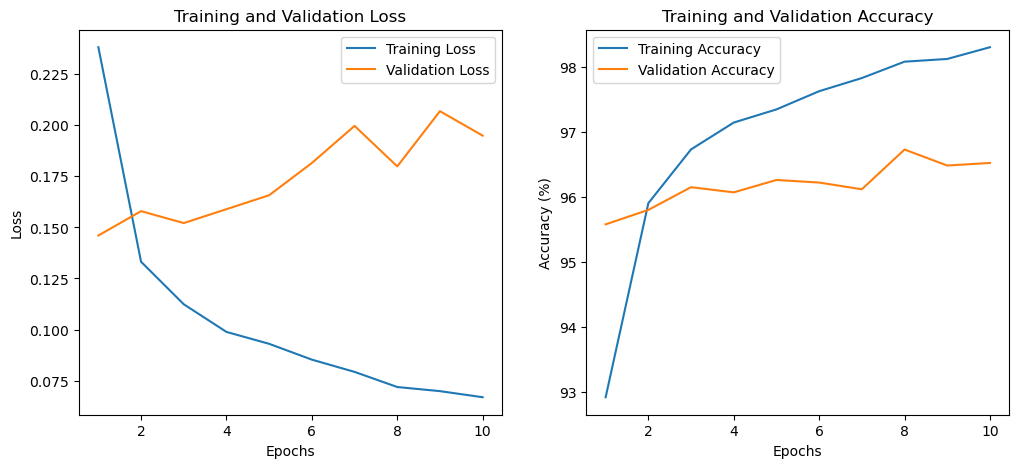

In [69]:
# Hyperparameters
input_size = 28 * 28  # Flatten MNIST images
hidden_size = 128
output_size = 10  # MNIST has 10 classes
batch_size = 64
learning_rate = 0.01
num_epochs = 10

# Load data
train_dataset, val_dataset, test_dataset = load_data()

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize the model, loss function, and optimizer
model = ShallowMLP(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()  # Suitable for classification
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# Train the model
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs)


## Test the model

In [71]:
test_loss, test_accuracy = evaluate_model(model, test_loader, criterion)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

Test Loss: 0.1751, Test Accuracy: 97.01%


## Hyperparameter Search
Search the hyperparameters that gives best accuracy 

In [85]:
import itertools

# Define the hyperparameter grid
learning_rates = [0.01, 0.001, 0.0001]
hidden_sizes = [64, 128, 256]
batch_sizes = [32, 64, 128]

# Define grid search function
def grid_search(train_dataset, val_dataset, test_dataset):
    best_model = None
    best_val_accuracy = 0
    best_hyperparams = {}

    # Iterate through all combinations of hyperparameters
    for lr, hidden_size, batch_size in itertools.product(learning_rates, hidden_sizes, batch_sizes):
       # print(f"Epoch {epoch+1}/{epoch}")
        #print(f"Epoch {epoch+1}/{epoch} ,Training with learning rate: {lr}, hidden size: {hidden_size}, batch size: {batch_size}")
        # DataLoaders
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

        # Initialize the model, loss function, and optimizer
        model = ShallowMLP(input_size, hidden_size, output_size)
        criterion = nn.CrossEntropyLoss()  # Suitable for classification
        optimizer = optim.Adam(model.parameters(), lr=lr)

        # Train the model
        train_losses, val_losses = [], []
        train_accuracies, val_accuracies = [], []

        print(f"Training with learning rate: {lr}, hidden size: {hidden_size}, batch size: {batch_size}")

        for epoch in range(num_epochs):
            model.train()
            train_loss = 0
            correct = 0
            total = 0
            
            for data, labels in train_loader:
                data = data.view(-1, input_size)  # Flatten the images
                
                # Forward pass
                outputs = model(data)
                loss = criterion(outputs, labels)
                
                # Backward pass and optimization
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                train_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                _, labels = torch.max(labels, 1)

                total += labels.size(0)
                correct += (predicted == labels).sum().item()
            
            train_accuracy = 100 * correct / total
            val_loss, val_accuracy = evaluate_model(model, val_loader, criterion)

            # Store loss and accuracy values for tracking
            train_losss=train_loss / len(train_loader)
            train_losses.append(train_losss)
            val_losses.append(val_loss)
            train_accuracies.append(train_accuracy)
            val_accuracies.append(val_accuracy)
            print(f"Epoch {epoch+1}/{num_epochs} ,Training accuracy: {train_accuracy:.2f}, validation accuracy: {val_accuracy:.2f}, training loss: {train_losss:.2f}, validation loss: {val_loss:.2f}")             
                  
        # Check if this model is the best so far
        if val_accuracies[-1] > best_val_accuracy:
            best_val_accuracy = val_accuracies[-1]
            best_model = model
            best_hyperparams = {
                "learning_rate": lr,
                "hidden_size": hidden_size,
                "batch_size": batch_size
            }

    # Output the best model and hyperparameters
    print(f"Best validation accuracy: {best_val_accuracy:.2f}%")
    print(f"Best hyperparameters: {best_hyperparams}")

    # Test the best model
    test_loader = DataLoader(test_dataset, batch_size=best_hyperparams["batch_size"], shuffle=False)
    test_loss, test_accuracy = evaluate_model(best_model, test_loader, criterion)
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")
    return best_hyperparams

In [87]:
# Run the grid search
best_hyperparams = grid_search(train_dataset, val_dataset, test_dataset)

Training with learning rate: 0.01, hidden size: 64, batch size: 32
Epoch 1/10 ,Training accuracy: 92.23, validation accuracy: 94.92, training loss: 0.26, validation loss: 0.18
Epoch 2/10 ,Training accuracy: 95.38, validation accuracy: 95.44, training loss: 0.16, validation loss: 0.17
Epoch 3/10 ,Training accuracy: 95.90, validation accuracy: 95.76, training loss: 0.14, validation loss: 0.17
Epoch 4/10 ,Training accuracy: 96.27, validation accuracy: 95.44, training loss: 0.13, validation loss: 0.19
Epoch 5/10 ,Training accuracy: 96.52, validation accuracy: 95.60, training loss: 0.13, validation loss: 0.20
Epoch 6/10 ,Training accuracy: 96.93, validation accuracy: 95.27, training loss: 0.11, validation loss: 0.22
Epoch 7/10 ,Training accuracy: 96.86, validation accuracy: 95.63, training loss: 0.11, validation loss: 0.22
Epoch 8/10 ,Training accuracy: 97.11, validation accuracy: 96.07, training loss: 0.11, validation loss: 0.20
Epoch 9/10 ,Training accuracy: 97.25, validation accuracy: 96

## Train the model with best param

Epoch [1/10], Train Loss: 0.0000, Train Accuracy: 100.00%, Val Loss: 0.2952, Val Accuracy: 97.75%
Epoch [2/10], Train Loss: 0.0000, Train Accuracy: 100.00%, Val Loss: 0.3082, Val Accuracy: 97.73%
Epoch [3/10], Train Loss: 0.0002, Train Accuracy: 99.99%, Val Loss: 0.2976, Val Accuracy: 97.67%
Epoch [4/10], Train Loss: 0.0000, Train Accuracy: 100.00%, Val Loss: 0.2920, Val Accuracy: 97.69%
Epoch [5/10], Train Loss: 0.0000, Train Accuracy: 100.00%, Val Loss: 0.2946, Val Accuracy: 97.67%
Epoch [6/10], Train Loss: 0.0000, Train Accuracy: 100.00%, Val Loss: 0.2959, Val Accuracy: 97.67%
Epoch [7/10], Train Loss: 0.0000, Train Accuracy: 100.00%, Val Loss: 0.2966, Val Accuracy: 97.71%
Epoch [8/10], Train Loss: 0.0000, Train Accuracy: 100.00%, Val Loss: 0.2984, Val Accuracy: 97.70%
Epoch [9/10], Train Loss: 0.0000, Train Accuracy: 100.00%, Val Loss: 0.3006, Val Accuracy: 97.73%
Epoch [10/10], Train Loss: 0.0000, Train Accuracy: 100.00%, Val Loss: 0.3017, Val Accuracy: 97.74%


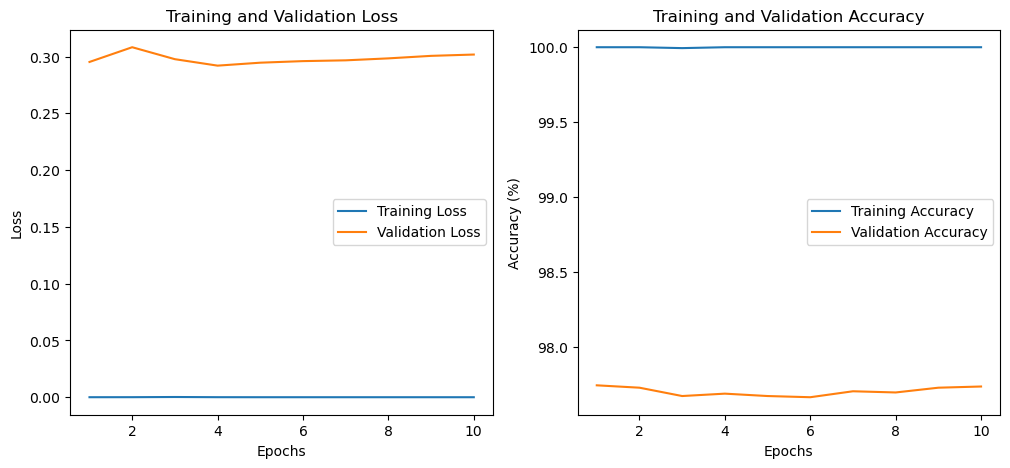

In [96]:
train_loader_with_best_parameter = DataLoader(train_dataset, batch_size=best_hyperparams["batch_size"], shuffle=True)
val_loader_with_best_parameter = DataLoader(val_dataset, batch_size=best_hyperparams["batch_size"], shuffle=True)
optimizer = optim.Adam(model.parameters(), lr=best_hyperparams["learning_rate"])
model_with_best_param = ShallowMLP(input_size, best_hyperparams["hidden_size"], output_size)

# Train the model with best param
train_model(model, train_loader, val_loader, criterion, optimizer, 10)

## Function to test hyperparameters
The influence of each hyperparameter on the performance. (we will take the best hyperparametes as fixed variables while we change the variable that will we test on )

In [100]:
# Function to test hyperparameters
def test_hyperparameters(hyperparam_name, values):
    results = {}
    for value in values:
        print(f"Testing {hyperparam_name} = {value}")
        #Best hyperparameters: {'learning_rate': 0.001, 'hidden_size': 256, 'batch_size': 128}
        # Set hyperparameters
        if hyperparam_name == 'learning_rate':
            learning_rate = value
            hidden_size = 256
            batch_size = 128
        elif hyperparam_name == 'hidden_size':
            learning_rate = 0.001
            hidden_size = value
            batch_size = 128
        elif hyperparam_name == 'batch_size':
            learning_rate = 0.001
            hidden_size = 128
            batch_size = value
        else:
            raise ValueError("Unsupported hyperparameter name.")
        
        # Load data
        train_dataset, val_dataset, test_dataset = load_data()
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
        
        # Initialize the model, loss function, and optimizer
        model = ShallowMLP(input_size, hidden_size, output_size)
        criterion = nn.CrossEntropyLoss()  # Suitable for classification
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)

        # Train the model
        train_losses, val_losses = [], []
        train_accuracies, val_accuracies = [], []

        print(f"Training with learning rate: {learning_rate}, hidden size: {hidden_size}, batch size: {batch_size}")

        for epoch in range(num_epochs):
            model.train()
            train_loss = 0
            correct = 0
            total = 0
            
            for data, labels in train_loader:
                data = data.view(-1, input_size)  # Flatten the images
                
                # Forward pass
                outputs = model(data)
                loss = criterion(outputs, labels)
                
                # Backward pass and optimization
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                train_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                _, labels = torch.max(labels, 1)

                total += labels.size(0)
                correct += (predicted == labels).sum().item()
            
            train_accuracy = 100 * correct / total
            val_loss, val_accuracy = evaluate_model(model, val_loader, criterion)

            # Store loss and accuracy values for tracking
            train_losss=train_loss / len(train_loader)
            train_losses.append(train_losss)
            val_losses.append(val_loss)
            train_accuracies.append(train_accuracy)
            val_accuracies.append(val_accuracy)

            print(f"Epoch {epoch+1}/{num_epochs} ,Training accuracy: {train_accuracy:.2f}, validation accuracy: {val_accuracy:.2f}, training loss: {train_losss:.2f}, validation loss: {val_loss:.2f}")             
            
        # Store results
        results[value] = {
            'train_losses': train_losses,
            'val_accuracies': val_accuracies
        }
    
    return results

## Influence of learning rate 

In [ ]:
# Test learning rate
learning_rates = [0.001, 0.01, 0.1]
learning_rate_results = test_hyperparameters('learning_rate', learning_rates)

Testing learning_rate = 0.001
Training with learning rate: 0.001, hidden size: 256, batch size: 128
Epoch 1/10 ,Training accuracy: 89.39, validation accuracy: 93.68, training loss: 0.39, validation loss: 0.22
Epoch 2/10 ,Training accuracy: 94.99, validation accuracy: 95.79, training loss: 0.17, validation loss: 0.15
Epoch 3/10 ,Training accuracy: 96.47, validation accuracy: 96.60, training loss: 0.12, validation loss: 0.12
Epoch 4/10 ,Training accuracy: 97.32, validation accuracy: 97.02, training loss: 0.09, validation loss: 0.10
Epoch 5/10 ,Training accuracy: 97.89, validation accuracy: 97.24, training loss: 0.07, validation loss: 0.10
Epoch 6/10 ,Training accuracy: 98.32, validation accuracy: 97.52, training loss: 0.06, validation loss: 0.09
Epoch 7/10 ,Training accuracy: 98.68, validation accuracy: 97.71, training loss: 0.05, validation loss: 0.08


In [ ]:

# Plot results
for lr, result in learning_rate_results.items():
    plt.plot(result['val_accuracies'], label=f'lr={lr}')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy vs Learning Rate')
plt.legend()
plt.show()


## Influence of hiddden size

In [ ]:
# Test hidden size
hidden_sizes = [64, 128, 256]
hidden_size_results = test_hyperparameters('hidden_size', hidden_sizes)

In [ ]:

# Plot results
for hs, result in hidden_size_results.items():
    plt.plot(result['val_accuracies'], label=f'hidden_size={hs}')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy vs Hidden Size')
plt.legend()
plt.show()

## Influence of batch size 

In [ ]:
# Test batch size
batch_sizes = [32, 64, 128]
batch_size_results = test_hyperparameters('batch_size', batch_sizes)

In [ ]:
# Plot results
for bs, result in batch_size_results.items():
    plt.plot(result['val_accuracies'], label=f'batch_size={bs}')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy vs Batch Size')
plt.legend()
plt.show()